<a href="https://colab.research.google.com/github/ejlee127/sound-learning/blob/main/train_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.1'
#spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [2,118 kB]
Get:15 ht

In [3]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2020-11-05 14:28:38--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  1.05MB/s    in 0.8s    

2020-11-05 14:28:40 (1.05 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [21]:
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import LabelEncoder
#from tensorflow.keras.utils import to_categorical

In [20]:
# AWS postgresSQL setting
# Configure settings for RDS
jdbc_url="jdbc:postgresql://urbansounddb.cwkue3lwi5mx.us-east-1.rds.amazonaws.com:5432/postgres"
config = {"user":"root", 
          "password": "urbansoundDB", 
          "driver":"org.postgresql.Driver"}

In [37]:
NUMFOLDS = 10
TESTFOLD = 10

def create_train_test_set():

  train_list = [ i for i in range(1,NUMFOLDS+1) if i is not TESTFOLD ]
  train_df = pd.DataFrame({})

  for i in train_list:
    print(i, train_df.shape)
    trainTable = f'fold{i}_mfcc'
    mfcc_df = spark.read.jdbc(url=jdbc_url, table=trainTable, properties=config)
    df_pandas = mfcc_df.toPandas()
    train_df = pd.concat([train_df, df_pandas])
  
  # Set the X_train and y_train from concatenated dataframe
  X_train = train_df.drop(['fileID', 'classID'], axis = 1)
  y_train = train_df['classID']

  # Set the X_test and y_test from TESTFOLD-Table
  testTable = f'fold{TESTFOLD}_mfcc'
  mfcc_df = spark.read.jdbc(url=jdbc_url, table=testTable, properties=config)
  test_df = mfcc_df.toPandas()
  print(test_df.shape)
  X_test = test_df.drop(['fileID', 'classID'], axis = 1)
  y_test = test_df['classID']

  return X_train, X_test, y_train, y_test

In [36]:
tmp_df = pd.DataFrame({})
tmp_df.head()

""


In [38]:
X_train, X_test, y_train, y_test = create_train_test_set()

1 (0, 0)
2 (3106, 574)
3 (6182, 574)
4 (9519, 574)
5 (12973, 574)
6 (16221, 574)
7 (19122, 574)
8 (22132, 574)
9 (24941, 574)
(2974, 574)


In [40]:
print(X_train.shape)

(27851, 572)


In [41]:
#from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [42]:
keras.backend.clear_session()

In [46]:
# build the network architecture
model = keras.Sequential([
    # input layer
    # keras.layers.Flatten(input_shape=(X_train.shape[1])),
    
    # lst hidden layer
    keras.layers.Dense(512, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # 2nd hidden layer
    keras.layers.Dense(512, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # 3rd hidden layer
    keras.layers.Dense(512, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # output layer
    keras.layers.Dense(10, activation="softmax")
])

In [48]:
# train network
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

## overfitting -- identify

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

871/871 [==============================] - 11s 12ms/step - loss: 4.9148 - accuracy: 0.3705 - val_loss: 3.0222 - val_accuracy: 0.4845
Epoch 2/50
871/871 [==============================] - 10s 12ms/step - loss: 2.7495 - accuracy: 0.4719 - val_loss: 2.7759 - val_accuracy: 0.5067
Epoch 3/50
871/871 [==============================] - 11s 12ms/step - loss: 2.4180 - accuracy: 0.5197 - val_loss: 2.5619 - val_accuracy: 0.4929
Epoch 4/50
871/871 [==============================] - 11s 12ms/step - loss: 

In [49]:
import matplotlib.pyplot as plt

def plot_history(history):
  fig, axs = plt.subplots(2)

  #create the accuracy subplot
  axs[0].plot(history.history["accuracy"],label="train accuracy")
  axs[0].plot(history.history["val_accuracy"],label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="best")
  axs[0].set_title("accuracy eval")

  # create accuracy
  axs[1].plot(history.history["loss"],label="train error")
  axs[1].plot(history.history["val_loss"],label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="best")
  axs[1].set_title("Error eval")

  plt.show()

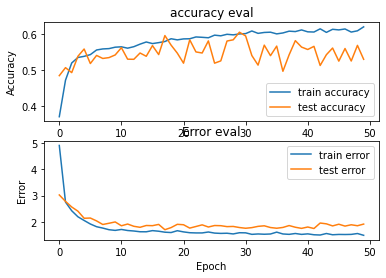

In [50]:
plot_history(model_history)

In [ ]:
# Save the model
model.save("sound_model_trained.h5")

In [ ]:
model_loss, model_accuracy = model.evaluate(
    X_test, y_test, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

292/292 - 1s - loss: 2.1765 - accuracy: 0.4687
Normal Neural Network - Loss: 2.1765217781066895, Accuracy: 0.46869638562202454
